# <center><font color=DarkBlue>Exploratory Analysis on Chlorophyll A Concentration Data from MODIS</center>
### <center><font color=DarkRed>University of Rochester</center> <font color=DarkRed>

Research suggests that there exists a relationship between chlorophyll a concentration and coral reef bleaching. To explore that relationship, this notebook extracts chlorophyll a data from MODIS - Terra and derives multiple features that would later on be used in the bleaching model to predict bleaching severity of coral reefs. 

These same features are also created for POC (particulate organic carbon) and NFLH (normalized fluorescence line height) data as these are collected for every instance of chlorophyll a and will potentially serve as useful features for the model. Research on the relationship between POC and NFLH was not performed as part of this project but could be studied should this project be further developed in the future.

In [303]:
#importing necessary libraries
import pandas as pd
from datetime import datetime
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from matplotlib import pyplot as plt
import warnings #used to avoid long warning about library deprication - could be removed
import seaborn as sns

## GCBD (Global Coral Bleaching Database) for GBR and Caribbean

In [304]:
#importing the GCBD dataset that includes data on latitudes and longitudes for both the 
#great barrier reef and the caribbean 
# dfGCBD = pd.read_csv('MeshedGCBD.csv',index_col=0)
# dfGCBD['Date'] = pd.to_datetime(dfGCBD['Date'])
# dfGCBD = dfGCBD.dropna(subset=['Date'])

# #deriving day, month, and year from the date column
# dfGCBD['day'] = dfGCBD['Date'].dt.day.astype(str).str.zfill(2)
# dfGCBD['month'] = dfGCBD['Date'].dt.month.astype(str).str.zfill(2)
# dfGCBD['year'] = dfGCBD['Date'].dt.year.astype(str).str.zfill(4)
dfGCBD.head(5)

,index,Latitude_Degrees,Longitude_Degrees,Percent_Bleached_Sum,day,month,year,lat_Rnd,lon_Rnd
0,0,24.366926,124.003372,75.00,8,9,2016,24.5,124.5
1,1,24.454807,124.109802,75.00,2,9,2016,24.5,124.5
2,3,24.463401,123.802185,32.85,5,8,2008,24.5,123.5
3,4,24.482618,124.125423,75.00,2,9,2016,24.5,124.5
4,5,24.483712,124.123192,75.00,1,10,2016,24.5,124.5


The below plots show the distribution of GCBD data that we have on the world map.

/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


Text(0.5, 1.0, 'Distribution of Global Coral Bleaching Database Data')

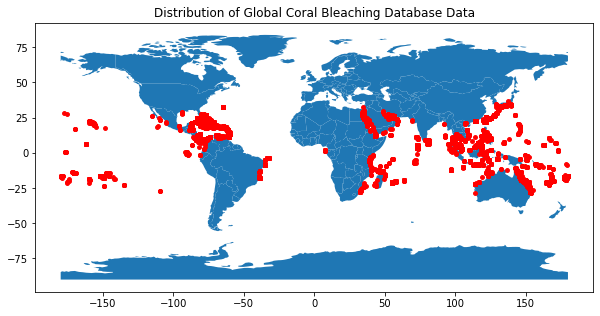

In [305]:
geometry = [Point(xy) for xy in zip(dfGCBD['Longitude_Degrees'], dfGCBD['Latitude_Degrees'])]
gdf = GeoDataFrame(dfGCBD, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);
plt.title("Distribution of Global Coral Bleaching Database Data")

The GCBD data is then divided into 2: GBR and Caribbean. This is done in case certain analysis needs to be made on one region independently and will be used in later sections of this notebook.

In [306]:
#Dividing GCBD into GBR and CAR
#the numerical values for lats and longs were set manually by our team as the limits to the GBR and Caribbean
#regions that we are studying as part of this project. These could be altered. 
gcbd_gbr = dfGCBD.loc[(((dfGCBD['Longitude_Degrees']> 142.69) & (dfGCBD['Longitude_Degrees']<153.7) \
                  & (dfGCBD['Latitude_Degrees']>-28.7)&(dfGCBD['Latitude_Degrees']<-10)))]
gcbd_car = dfGCBD.loc[(dfGCBD['Longitude_Degrees']> -85) & (dfGCBD['Longitude_Degrees']<-63) &  
                      (dfGCBD['Latitude_Degrees']>17)&(dfGCBD['Latitude_Degrees']<27)]

/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


Text(0.5, 1.0, 'GBR Bleaching Data Points')

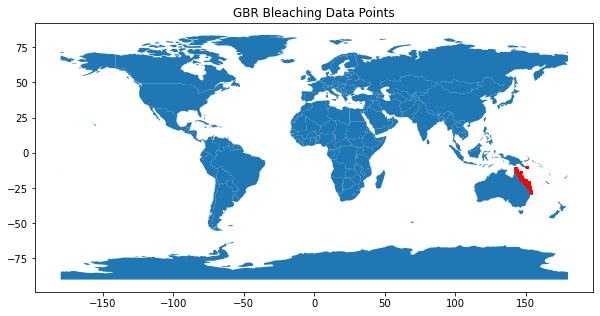

In [307]:
geometry1 = [Point(xy) for xy in zip(gcbd_gbr['Longitude_Degrees'], gcbd_gbr['Latitude_Degrees'])]
gdf1 = GeoDataFrame(gcbd_gbr, geometry=geometry1) 
gdf1.plot(ax=world.plot(figsize=(10, 6)), marker='.', color='red', markersize=15)
plt.title("GBR Bleaching Data Points")

/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


Text(0.5, 1.0, 'Caribbean Bleaching Data Points')

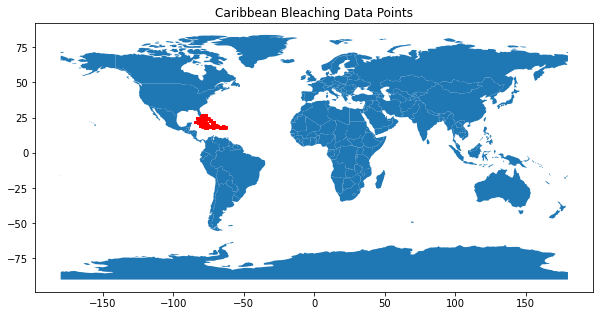

In [308]:
geometry2 = [Point(xy) for xy in zip(gcbd_car['Longitude_Degrees'], gcbd_car['Latitude_Degrees'])]
gdf2 = GeoDataFrame(gcbd_car, geometry=geometry2) 
gdf2.plot(ax=world.plot(figsize=(10, 6)), marker='.', color='red', markersize=15)
plt.title("Caribbean Bleaching Data Points")

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  - - - - - - - - - - - - - 

# Collecting Data from MODIS

The data is collected using the Google Earth Search Engine. Upon running the code block below, the authentication token will be needed. This requires a valid Google account. The url will materialize after running the code and should be clicked. Instructions after that are straightforward. Follow the steps promted by Google and copy paste the token into the box below.

In [311]:
# MODIS EXTRACTION
import ee
from ee import EEException
import pandas as pd
ee.Authenticate(quiet=True)
ee.Initialize()

Paste the following address into a web browser:

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=NLaHOncz3FYfbXwqOfE474_zwf7s2OsNzIgMl1NFADw&tc=D0sp3XJPpeaKtFs49muOEP4CtmtQ-ugbR_jN_CZb6ZQ&cc=5fQv86mOpS8Xcl-lUliec-8s100P3GVhW5cut-RDmyQ

On the web page, please authorize access to your Earth Engine account and copy the authentication code. Next authenticate with the following command:

    earthengine authenticate --code-verifier=NLaHOncz3FYfbXwqOfE474_zwf7s2OsNzIgMl1NFADw:jB47dhSbIRXLq5o6mOoPhI015A1Uqmh4RXqhY3K99lg:EVrvUVVYqXJqH63l7xVwOxfmAx9Kyd8K6d_HyRuUwP4 --authorization-code=PLACE_AUTH_CODE_HERE

Enter verification code: 4/1AfgeXvuOsw6ptnL8kb2IAdWQno2UHiVz5pLlpkl-mj2ygiSsyDme8mj8QiE

Successfully saved authorization token.


### Row Testing:
Code below tests that the code for data collection through MODIS works. It only collects data for chlorophyll a, but this will be expanded on later on in this notebook. 

The code runs in the following fashion:
- Takes a row from the GCBD dataframe as input
- Uses the lat, long, year, month, and day from that row as collects the MODIS data for those specific values
- Returns all MODIS data at the specified lat/long for 90 days in advance of the date in GCBD dataset
- Creates a new date column

In [142]:
row = gcbd_gbr.iloc[11]

chlor = ee.ImageCollection("NASA/OCEANDATA/MODIS-Aqua/L3SMI").select(['chlor_a'])
date = ee.Date(f"{row['year']}-{row['month']}-{row['day']}")
point = ee.Geometry.Point([row['Longitude_Degrees'], row['Latitude_Degrees']])
image = chlor.filterBounds(geometry=point).filterDate(date.advance(-90, 'day'), date)
data = image.getRegion(geometry=ee.Geometry.Point([row['Longitude_Degrees'], row['Latitude_Degrees']]), scale=5000).getInfo()
df = pd.DataFrame(data[1:], columns=data[0])
df['time']=df.time.apply(lambda x: datetime.fromtimestamp(x/1000))
df=df.dropna()
df['date'],df['time'] = zip(*[(d.date(), d.time()) for d in df['time']])
df

,id,longitude,latitude,time,chlor_a,date
8,A2010273,150.89451,-23.064245,20:25:01,2.213068,2010-09-29
13,A2010278,150.89451,-23.064245,20:45:01,1.127264,2010-10-04
15,A2010280,150.89451,-23.064245,20:30:00,1.886479,2010-10-06
24,A2010289,150.89451,-23.064245,20:25:01,2.453274,2010-10-15
26,A2010291,150.89451,-23.064245,20:10:01,3.541672,2010-10-17
31,A2010296,150.89451,-23.064245,20:30:00,1.959838,2010-10-22
33,A2010298,150.89451,-23.064245,20:20:00,2.697273,2010-10-24
74,A2010339,150.89451,-23.064245,19:10:00,5.068055,2010-12-04


## Collecting MODIS data for Great Barrier Reef GCBD points
### This section is more focused on testing code functionality and exploring the output 

The below code block collects chlor_a, sst (sea surface temperature), nflh, and poc data for the lats and longs found in the GBR GCBD dataframe. 

~ note that this could be generalized to collect from the comprehensive GCBD database rather than the GBR one.

In each run of the for loop, the data is being collected in the form of a dataframe for a specific long and lat found in the row in GCBD. Line 27 concats the results of the current loop to all previous ones. The output of this code is a dataframe that includes every historical data point collected for each lat/long/date (in a 90 day range). Therefore, the size of the resulting dataframe is much larger than that of GCBD since every point in GCBD has multiple readings from MODIS in the 90 day period.

In [194]:
#CODE COLLECTING MODIS DATA FOR ALL POINTS IN GCBD - gbr

warnings.filterwarnings('ignore')
dfk= pd.DataFrame([])
for i in range(len(gcbd_gbr)):
    try:
        row = gcbd_gbr.iloc[i]
        chlor = ee.ImageCollection("NASA/OCEANDATA/MODIS-Aqua/L3SMI").select(['chlor_a','sst','nflh','poc'])
        date = ee.Date(f"{row['year']}-{row['month']}-{row['day']}")
        point = ee.Geometry.Point([row['Longitude_Degrees'], row['Latitude_Degrees']])
        image = chlor.filterBounds(geometry=point).filterDate(date.advance(-90, 'day'), date)
        data = image.getRegion(geometry=ee.Geometry.Point([row['Longitude_Degrees'], row['Latitude_Degrees']]), scale=5000).getInfo()
        df = pd.DataFrame(data[1:], columns=data[0])
        df['time']=df.time.apply(lambda x: datetime.fromtimestamp(x/1000))
        df=df.dropna()
        
        try:
            df['date'],df['time'] = zip(*[(d.date(), d.time()) for d in df['time']]) 
        except:
            df['date'],df['time'] = np.nan, np.nan
            
    except EEException:
        df['chlor_a'] = np.nan
        df['sst'] = np.nan
        df['nflh'] = np.nan
        df['poc'] = np.nan
    dfk=pd.concat([dfk,df]) 

In [199]:
#print(len(dfk))
#checking for null values collected
dfk.isna().sum()

id              0
longitude       0
latitude        0
time            0
chlor_a      3065
sst          3065
nflh         3065
poc          3065
date            0
dtype: int64

In [200]:
#exporting the output dataframe as a pickle file
dfk.to_pickle('gbr_chlor_data.pkl')

### The below code is a replication of the above but for the Caribbean

In [201]:
#CODE COLLECTING MODIS DATA FOR ALL POINTS IN GCBD - caribbean
import warnings
warnings.filterwarnings('ignore')
dfs= pd.DataFrame([])
for i in range(len(gcbd_car)):
    try:
        row = gcbd_car.iloc[i]
        chlor = ee.ImageCollection("NASA/OCEANDATA/MODIS-Aqua/L3SMI").select(['chlor_a','sst','nflh','poc'])
        date = ee.Date(f"{row['year']}-{row['month']}-{row['day']}")
        point = ee.Geometry.Point([row['Longitude_Degrees'], row['Latitude_Degrees']])
        image = chlor.filterBounds(geometry=point).filterDate(date.advance(-90, 'day'), date)
        data = image.getRegion(geometry=ee.Geometry.Point([row['Longitude_Degrees'], row['Latitude_Degrees']]), scale=5000).getInfo()
        df = pd.DataFrame(data[1:], columns=data[0])
        df['time']=df.time.apply(lambda x: datetime.fromtimestamp(x/1000))
        df=df.dropna()
        
        try:
            df['date'],df['time'] = zip(*[(d.date(), d.time()) for d in df['time']]) 
        except:
            df['date'],df['time'] = np.nan, np.nan
            
    except EEException:
        df['chlor_a'] = np.nan
        df['sst'] = np.nan
        df['nflh'] = np.nan
        df['poc'] = np.nan
    dfs=pd.concat([dfs,df])

In [202]:
#exporting to pickle file
dfs.to_pickle('car_chlor_data.pkl')

In [203]:
print(len(dfs))
dfs.head(5)

51387


,id,longitude,latitude,time,chlor_a,sst,nflh,poc,date
7,A2004145,-81.095412,24.636297,20:50:00,0.47221,26.775,0.04408,138.399994,2004-05-23
8,A2004146,-81.095412,24.636297,20:05:01,0.59681,26.689999,0.063715,156.0,2004-05-24
9,A2004147,-81.095412,24.636297,20:40:01,1.464179,27.705,0.04918,295.799988,2004-05-25
14,A2004152,-81.095412,24.636297,20:50:01,0.68348,27.965,0.049435,167.199997,2004-05-30
16,A2004154,-81.095412,24.636297,20:45:01,0.467872,28.555,0.05921,118.0,2004-06-01


The above dataframe shows a sample of what the code above generates. As observed, each MODIS reading has its own ID, and each lat/long combination has multiple readings across the 90 days prior to the current date (the one present in the GCBD dataset). These are all compiled into one dataframe. 

In [8]:
#reading in the pickle files created
car_chlor = pd.read_pickle('car_chlor_data.pkl')
gbr_chlor = pd.read_pickle('gbr_chlor_data.pkl')

The below code section combines both data files into one comprehensive dataframe that captures data from Great Barrier Reef and the Caribbean. 

In [68]:
car_chlor['date'] = pd.to_datetime(car_chlor['date'])
gbr_chlor['date'] = pd.to_datetime(gbr_chlor['date'])
chlor = pd.concat([car_chlor, gbr_chlor])
#chlor=chlor.dropna()
chlor

,id,longitude,latitude,time,chlor_a,sst,nflh,poc,date
7,A2004145,-81.095412,24.636297,20:50:00,0.47221,26.775,0.04408,138.399994,2004-05-23
8,A2004146,-81.095412,24.636297,20:05:01,0.59681,26.689999,0.063715,156.0,2004-05-24
9,A2004147,-81.095412,24.636297,20:40:01,1.464179,27.705,0.04918,295.799988,2004-05-25
14,A2004152,-81.095412,24.636297,20:50:01,0.68348,27.965,0.049435,167.199997,2004-05-30
16,A2004154,-81.095412,24.636297,20:45:01,0.467872,28.555,0.05921,118.0,2004-06-01
...,...,...,...,...,...,...,...,...,...
50,A2007309,145.819028,-16.057386,19:50:00,NaN,NaN,NaN,NaN,2007-11-04
52,A2007311,145.819028,-16.057386,19:35:01,NaN,NaN,NaN,NaN,2007-11-06
68,A2007327,145.819028,-16.057386,19:35:01,NaN,NaN,NaN,NaN,2007-11-22
73,A2007332,145.819028,-16.057386,19:00:01,NaN,NaN,NaN,NaN,2007-11-27


In [69]:
chlor=chlor.dropna()
chlor.to_pickle('comprehensive_modis_data_NOGCBD.pkl')

## MODIS Data Analysis

This section of the notebook aims at understanding the content of the dataframe generated by collecting the data from MODIS. 

In [14]:
#checing for GCBD dataset datatypes to ensure the collected data and GCBD data are compatible for working on
dfGCBD.dtypes

Latitude_Degrees               float64
Longitude_Degrees              float64
Date                    datetime64[ns]
Percent_Bleached_Sum           float64
Percent_Cover_Sum              float64
day                             object
month                           object
year                            object
dtype: object

In [43]:
#checing for chlor dataset datatypes 
chlor.dtypes

id                   object
longitude           float64
latitude            float64
time                 object
chlor_a              object
sst                  object
nflh                 object
poc                  object
date         datetime64[ns]
dtype: object

In [44]:
dfGCBD.head(2)

,Latitude_Degrees,Longitude_Degrees,Date,Percent_Bleached_Sum,Percent_Cover_Sum,day,month,year
33647,-10.300000,150.416000,2000-01-15,31.600000,NaN,15,01,2000
35882,18.317867,-64.990733,2000-06-12,20.353836,NaN,12,06,2000


In [70]:
chlor.head(2)

,id,longitude,latitude,time,chlor_a,sst,nflh,poc,date
7,A2004145,-81.095412,24.636297,20:50:00,0.47221,26.775,0.04408,138.399994,2004-05-23
8,A2004146,-81.095412,24.636297,20:05:01,0.59681,26.689999,0.063715,156.0,2004-05-24


In [46]:
#sorting both dataframes on date, lats and longs
chlor=chlor.sort_values(by=['date','latitude','longitude'])
dfGCBD=dfGCBD.sort_values(by=['Date','Latitude_Degrees','Longitude_Degrees'])

In [47]:
#getting the date range found in GCBD
print(dfGCBD.Date.min())
print(dfGCBD.Date.max())

2000-01-15 00:00:00
2019-08-24 00:00:00


In [48]:
#getting the date range found in chlor
print(chlor.date.min())
print(chlor.date.max())

2002-12-21 00:00:00
2019-08-16 00:00:00


Now, to illustrate changes in poc, nflh, and chlor_a, a single lat/long point is selected. 

The dataframe is grouped by latitude and longitude in order to find a point that has many readings through MODIS. 

In [127]:
pop=chlor.groupby(['latitude','longitude']).count().reset_index()
pop

,latitude,longitude,id,time,chlor_a,sst,nflh,poc,date
0,-28.184642,153.544540,5,5,5,5,5,5,5
1,-27.825316,153.454708,1,1,1,1,1,1,1
2,-27.555821,153.364877,5,5,5,5,5,5,5
3,-27.510906,153.364877,104,104,104,104,104,104,104
4,-27.465990,153.364877,89,89,89,89,89,89,89
...,...,...,...,...,...,...,...,...,...
578,26.657506,-80.017434,26,26,26,26,26,26,26
579,26.702422,-80.017434,64,64,64,64,64,64,64
580,26.747338,-80.017434,6,6,6,6,6,6,6
581,26.882085,-80.017434,1,1,1,1,1,1,1


In [201]:
#This is a filtering technique to narrow down to the one point found on index three of the above dataframe
df_sample=chlor[(chlor['longitude']>=153.3648) & (chlor['longitude']<153.3649) & (chlor['latitude']>=-27.510909) & (chlor['latitude']<-27.510905)]
df_sample=df_sample.sort_values(by='date')
df_sample['date']=df_sample['date'].astype(str)
df_sample

,id,longitude,latitude,time,chlor_a,sst,nflh,poc,date
2,A2009240,153.364877,-27.510906,20:45:01,4.589216,21.029999,0.106385,656.599976,2009-08-27
13,A2009251,153.364877,-27.510906,20:30:01,2.955949,21.424999,0.157895,389.200012,2009-09-07
18,A2009256,153.364877,-27.510906,20:15:00,4.460639,21.309999,0.06635,548.400024,2009-09-12
29,A2009267,153.364877,-27.510906,20:30:00,3.91916,22.305,0.202605,607.200012,2009-09-23
41,A2009279,153.364877,-27.510906,20:20:01,3.553432,22.674999,0.2083,412.200012,2009-10-05
...,...,...,...,...,...,...,...,...,...
12,A2017253,153.364877,-27.510906,20:20:01,2.85474,19.975,0.20337,374.799988,2017-09-09
72,A2017301,153.364877,-27.510906,20:15:00,2.857313,23.775,0.175065,373.200012,2017-10-27
60,A2017301,153.364877,-27.510906,20:15:00,2.857313,23.775,0.175065,373.200012,2017-10-27
61,A2017301,153.364877,-27.510906,20:15:00,2.857313,23.775,0.175065,373.200012,2017-10-27


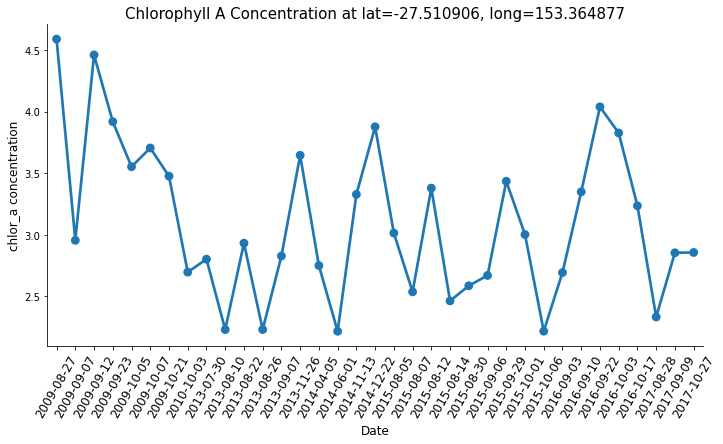

In [202]:
sns.catplot(x = 'date', y = 'chlor_a', data = df_sample,height=5, aspect=2, kind='point')
plt.xlabel("Date", fontsize=12)
plt.ylabel("chlor_a concentration", fontsize=12)
plt.title("Chlorophyll A Concentration at lat=-27.510906, long=153.364877", fontsize=15)
plt.xticks(rotation = 60, fontsize=12)

plt.show()

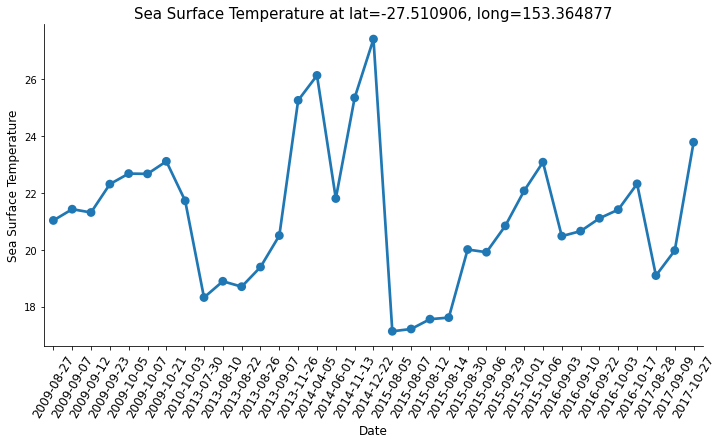

In [203]:
sns.catplot(x = 'date', y = 'sst', data = df_sample,height=5, aspect=2, kind='point')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sea Surface Temperature", fontsize=12)
plt.title("Sea Surface Temperature at lat=-27.510906, long=153.364877", fontsize=15)
plt.xticks(rotation = 60, fontsize=12)

plt.show()

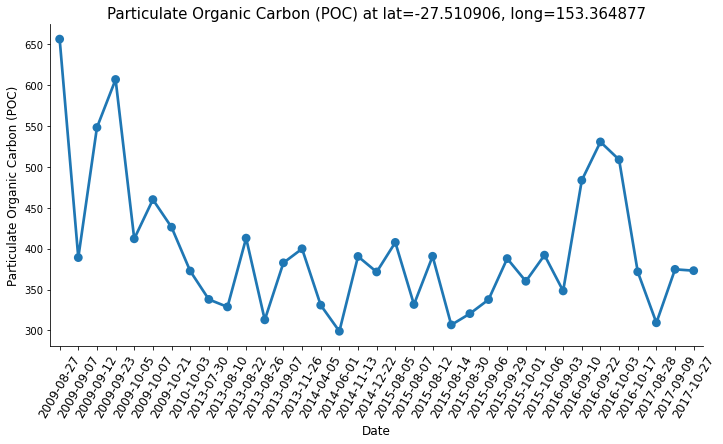

In [215]:
sns.catplot(x = 'date', y = 'poc', data = df_sample,height=5, aspect=2, kind='point')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Particulate Organic Carbon (POC)", fontsize=12)
plt.title("Particulate Organic Carbon (POC) at lat=-27.510906, long=153.364877", fontsize=15)
plt.xticks(rotation = 60, fontsize=12)

plt.show()

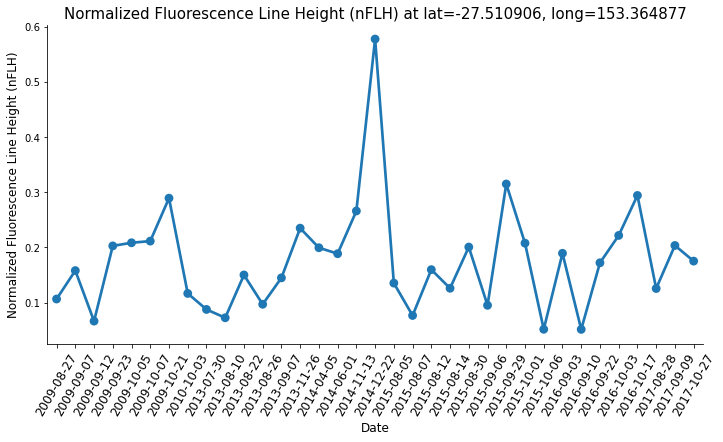

In [216]:
sns.catplot(x = 'date', y = 'nflh', data = df_sample,height=5, aspect=2, kind='point')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Normalized Fluorescence Line Height (nFLH)", fontsize=12)
plt.title("Normalized Fluorescence Line Height (nFLH) at lat=-27.510906, long=153.364877", fontsize=15)
plt.xticks(rotation = 60, fontsize=12)

plt.show()

In [251]:
temp=pd.DataFrame(chlor.groupby(['latitude','longitude'])['chlor_a'].mean())

(array([427.,  66.,  35.,  30.,  14.,   4.,   5.,   1.,   0.,   1.]),
 array([0.04990074, 0.64587607, 1.2418514 , 1.83782673, 2.43380206,
        3.02977739, 3.62575272, 4.22172805, 4.81770338, 5.41367872,
        6.00965405]),
 <BarContainer object of 10 artists>)

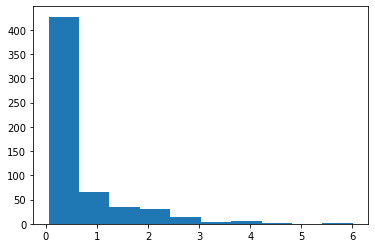

In [253]:
counts, bins = np.histogram(temp)
plt.hist(bins[:-1], bins, weights=counts)

# Feature Engineering on MODIS Data

In this section, we study different features that could be derived from chlor_a, poc, and nflh and could be of added value to our predictive model. SST features are analyzed in a separate notebook.

### Row Testing:
Code below tests that the code for data collection through MODIS works. It collects the data from MODIS for chlor_a, poc, and nflh.

The code runs in the following fashion:
- Takes a row from the GCBD dataframe as input
- Uses the lat, long, year, month, and day from that row as collects the MODIS data for those specific values
- Returns all MODIS data at the specified lat/long for 90 days in advance of the date in GCBD dataset
- Creates a new date column

Below is an explanation of each new column created and its use:
- change: returns number of days between the first and last observation in the 90-day period window
- chlor_avg, poc_avg, nflh_avg: return the average of chlor_a, poc, and nflh respectively for all the observations on the specified lat/long
- chlor_max, poc_max, nflh_max: return the maximum value of chlor_a, poc, and nflh respectively across all the observations on the specified lat/long
- chlor_min, poc_min, nflh_min: return the minimum value of chlor_a, poc, and nflh respectively across all the observations on the specified lat/long
- tot_days: returns the number of days between first and last observation (it is the stripped version of the change column)
- chlor_change, poc_change, nflh_change: return the change observed in chlor_a, poc, and nflh values respectively between the first and last reading

The above generated features help derive insight into the conditions of the reefs at the latitude and longitude at every point in the GCBD. 

In [312]:
row = dfGCBD.iloc[1398]

chlor = ee.ImageCollection("NASA/OCEANDATA/MODIS-Aqua/L3SMI").select(['chlor_a','nflh','poc'])
date = ee.Date(f"{row['year']}-{row['month']}-{row['day']}")
point = ee.Geometry.Point([row['Longitude_Degrees'], row['Latitude_Degrees']])
image = chlor.filterBounds(geometry=point).filterDate(date.advance(-45, 'day'), date)
data = image.getRegion(geometry=ee.Geometry.Point([row['Longitude_Degrees'], row['Latitude_Degrees']]), scale=5000).getInfo()
df = pd.DataFrame(data[1:], columns=data[0])

df['time']=df.time.apply(lambda x: datetime.fromtimestamp(x/1000))
df=df.dropna()

try:
    df['date'],df['time'] = zip(*[(d.date(), d.time()) for d in df['time']]) 
except:
    df['date'],df['time'] = np.nan, np.nan

df['change'] = df.date - df.date.shift(1)
df['chlor_avg']=np.mean(df['chlor_a'])
df['nflh_avg']=np.mean(df['nflh'])
df['poc_avg']=np.mean(df['poc'])
df['chlor_max']=np.max(df['chlor_a'])
df['nflh_max']=np.max(df['nflh'])
df['poc_max']=np.max(df['poc'])
df['chlor_min']=np.min(df['chlor_a'])
df['nflh_min']=np.min(df['nflh'])
df['poc_min']=np.min(df['poc'])
df['tot_days']=str(df.change.sum())
df['tot_days']=df.tot_days.str.extract('(\d+)')
df['chlor_change']=float(df['chlor_a'][-1:])-float(df['chlor_a'][:1])
df['nflh_change']=float(df['nflh'][-1:])-float(df['nflh'][:1])
df['poc_change']=float(df['poc'][-1:])-float(df['poc'][:1])

In [313]:
df

,id,longitude,latitude,time,chlor_a,nflh,poc,date,change,chlor_avg,...,chlor_max,nflh_max,poc_max,chlor_min,nflh_min,poc_min,tot_days,chlor_change,nflh_change,poc_change
14,A2010192,-80.646255,24.860875,20:15:01,1.338188,0.037450,241.800003,2010-07-10,NaT,0.820478,...,1.59724,0.07128,300.600006,0.138986,-0.000205,57.200001,26,-0.95355,0.0187,-141.400002
31,A2010209,-80.646255,24.860875,20:50:01,0.138986,0.041275,57.200001,2010-07-27,17 days,0.820478,...,1.59724,0.07128,300.600006,0.138986,-0.000205,57.200001,26,-0.95355,0.0187,-141.400002
32,A2010210,-80.646255,24.860875,20:05:01,0.419038,0.053940,126.400002,2010-07-28,1 days,0.820478,...,1.59724,0.07128,300.600006,0.138986,-0.000205,57.200001,26,-0.95355,0.0187,-141.400002
33,A2010211,-80.646255,24.860875,20:40:01,1.597240,-0.000205,300.600006,2010-07-29,1 days,0.820478,...,1.59724,0.07128,300.600006,0.138986,-0.000205,57.200001,26,-0.95355,0.0187,-141.400002
38,A2010216,-80.646255,24.860875,20:55:01,1.044775,0.071280,230.199997,2010-08-03,5 days,0.820478,...,1.59724,0.07128,300.600006,0.138986,-0.000205,57.200001,26,-0.95355,0.0187,-141.400002
40,A2010218,-80.646255,24.860875,20:45:00,0.384639,0.056150,100.400002,2010-08-05,2 days,0.820478,...,1.59724,0.07128,300.600006,0.138986,-0.000205,57.200001,26,-0.95355,0.0187,-141.400002


### Data Collection Function

This code incorporates the above into a function that performs all the calculations and returns the output. For each row in the GCB Dataset, the features (explained above) are calculated and returned. Unlike the code in the previous section that concatenates all readings for each GCBD point, this one only returns one row for each GCBD instance. This leads to the chlor_a, poc_ and nflh columns in this output being irrelevant as they are reflective of only one data point from MODIS and therefore we will delete these from the output dataframe. 

In [314]:
def getModisData(row):
    import warnings
    warnings.filterwarnings('ignore')

    try:
        #if(row.index % 250 == 0):
        #    print("Row:",row.index)
        chlor = ee.ImageCollection("NASA/OCEANDATA/MODIS-Aqua/L3SMI").select(['chlor_a', 'nflh','poc'])
        date = ee.Date(f"{row['year']}-{row['month']}-{row['day']}")
        point = ee.Geometry.Point([row['Longitude_Degrees'], row['Latitude_Degrees']])
        image = chlor.filterBounds(geometry=point).filterDate(date.advance(-30, 'day'), date)
        data = image.getRegion(geometry=ee.Geometry.Point([row['Longitude_Degrees'], row['Latitude_Degrees']]), scale=5000).getInfo()
        df = pd.DataFrame(data[1:], columns=data[0])
        
        df['time']=df.time.apply(lambda x: datetime.fromtimestamp(x/1000))
        df=df.dropna()

        try:
            df['date'],df['time'] = zip(*[(d.date(), d.time()) for d in df['time']]) 
        except:
            df['date'],df['time'] = np.nan, np.nan
            
        
        if df.shape[0]==0:
            row['chlor_avg'] = np.nan
            row['nflh_avg'] = np.nan
            row['poc_avg'] = np.nan
            row['chlor_min'] = np.nan
            row['nflh_min'] = np.nan
            row['poc_min'] = np.nan
            row['chlor_max'] = np.nan
            row['nflh_max'] = np.nan
            row['poc_max'] = np.nan
            row['poc_change'] = np.nan
            row['chlor_change'] = np.nan
            row['nflh_change'] = np.nan
            row['time_span'] = np.nan
        elif df.shape[0] >= 1:
            
            df['change'] = df.date - df.date.shift(1)
            df['chlor_avg']=np.mean(df['chlor_a'])
            df['nflh_avg']=np.mean(df['nflh'])
            df['poc_avg']=np.mean(df['poc'])
            df['chlor_max']=np.max(df['chlor_a'])
            df['nflh_max']=np.max(df['nflh'])
            df['poc_max']=np.max(df['poc'])
            df['chlor_min']=np.min(df['chlor_a'])
            df['nflh_min']=np.min(df['nflh'])
            df['poc_min']=np.min(df['poc'])
            df['tot_days']=str(df.change.sum())
            df['tot_days']=df.tot_days.str.extract('(\d+)')
            df['chlor_change']=float(df['chlor_a'][-1:])-float(df['chlor_a'][:1])
            df['nflh_change']=float(df['nflh'][-1:])-float(df['nflh'][:1])
            df['poc_change']=float(df['poc'][-1:])-float(df['poc'][:1])
            row['chlor_avg'] = df.iloc[0,]['chlor_avg']
            row['nflh_avg'] = df.iloc[0,]['nflh_avg']
            row['poc_avg'] = df.iloc[0,]['poc_avg']
            row['chlor_min'] = df.iloc[0,]['chlor_min']
            row['nflh_min'] = df.iloc[0,]['nflh_min']
            row['poc_min'] = df.iloc[0,]['poc_min']
            row['chlor_max'] = df.iloc[0,]['chlor_min']
            row['nflh_max'] = df.iloc[0,]['nflh_max']
            row['poc_max'] = df.iloc[0,]['poc_max']
            row['poc_change'] = df.iloc[0,]['poc_change']
            row['chlor_change'] = df.iloc[0,]['chlor_change']
            row['nflh_change'] = df.iloc[0,]['nflh_change']
            row['time_span'] = df.iloc[0,]['tot_days']
            
        return row
    except EEException:
        row['chlor_a'] = np.nan
        row['nflh'] = np.nan
        row['poc'] = np.nan
        return row

### Data Collection & Cleaning

In [318]:
import time
st = time.time()

dfGCBDModis = dfGCBD.apply(getModisData,axis=1)

et = time.time()

elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 8165.083453178406 seconds


In [319]:
dfGCBDModis

,Latitude_Degrees,Longitude_Degrees,Percent_Bleached_Sum,chlor_a,chlor_avg,chlor_change,chlor_max,chlor_min,day,geometry,...,nflh_change,nflh_max,nflh_min,poc,poc_avg,poc_change,poc_max,poc_min,time_span,year
0,24.366926,124.003372,75.00,NaN,NaN,NaN,NaN,NaN,8,POINT (124.0033722 24.36692592),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
1,24.454807,124.109802,75.00,NaN,0.204737,0.000000,0.204737,0.204737,2,POINT (124.1098022 24.45480663),...,0.00000,0.048925,0.048925,NaN,62.799999,0.000000,62.799999,62.799999,0,2016
2,24.463401,123.802185,32.85,NaN,0.113181,-0.000696,0.112833,0.112833,5,POINT (123.8021851 24.46340071),...,-0.02142,0.025635,0.004215,NaN,46.900000,4.600002,49.200001,44.599998,1,2008
3,24.482618,124.125423,75.00,NaN,0.119977,0.068623,0.098090,0.098090,2,POINT (124.1254234 24.48261807),...,-0.00306,0.052070,0.024105,NaN,43.950000,15.400002,53.400002,38.000000,11,2016
4,24.483712,124.123192,75.00,NaN,0.147708,0.000000,0.147708,0.147708,1,POINT (124.1231918 24.48371165),...,0.00000,0.059975,0.059975,NaN,46.400002,0.000000,46.400002,46.400002,0,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22950,12.028167,-61.783111,0.00,NaN,NaN,NaN,NaN,NaN,18,POINT (-61.78311111 12.02816667),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
22951,12.045639,-61.764917,0.00,NaN,NaN,NaN,NaN,NaN,26,POINT (-61.76491667 12.04563889),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
22952,12.045639,-61.764917,0.00,NaN,NaN,NaN,NaN,NaN,26,POINT (-61.76491667 12.04563889),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
22953,12.041444,-61.770944,0.00,NaN,NaN,NaN,NaN,NaN,11,POINT (-61.77094444 12.04144444),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015


Below, we try to understand what data types we have collected, what data is missing, and save the final output into a datarame. 

In [323]:
dfGCBDModis.isna().sum()
#we can see that there are 2757 points in GCBD that do not have corresponding points collected through MODIS

Latitude_Degrees            0
Longitude_Degrees           0
Percent_Bleached_Sum        0
chlor_a                 22955
chlor_avg               11394
chlor_change            11394
chlor_max               11394
chlor_min               11394
day                         0
geometry                    0
index                       0
lat_Rnd                     0
lon_Rnd                     0
month                       0
nflh                    22955
nflh_avg                11394
nflh_change             11394
nflh_max                11394
nflh_min                11394
poc                     22955
poc_avg                 11394
poc_change              11394
poc_max                 11394
poc_min                 11394
time_span               11394
year                        0
dtype: int64

In [23]:
dfGCBDModis.dtypes

Date                    datetime64[ns]
Latitude_Degrees               float64
Longitude_Degrees              float64
Percent_Bleached_Sum           float64
Percent_Cover_Sum              float64
chlor_a                        float64
chlor_avg                      float64
chlor_change                   float64
chlor_max                      float64
chlor_min                      float64
day                             object
month                           object
nflh                           float64
nflh_avg                       float64
nflh_change                    float64
nflh_max                       float64
nflh_min                       float64
poc                            float64
poc_avg                        float64
poc_change                     float64
poc_max                        float64
poc_min                        float64
time_span                       object
year                            object
dtype: object

In [321]:
#dropping irrelevant columns and nulls
df_update = dfGCBDModis.drop(columns=['chlor_a','nflh','poc'])
df_update.isna().sum()
df_update=df_update.dropna()
df_update.isna().sum()

Latitude_Degrees        0
Longitude_Degrees       0
Percent_Bleached_Sum    0
chlor_avg               0
chlor_change            0
chlor_max               0
chlor_min               0
day                     0
geometry                0
index                   0
lat_Rnd                 0
lon_Rnd                 0
month                   0
nflh_avg                0
nflh_change             0
nflh_max                0
nflh_min                0
poc_avg                 0
poc_change              0
poc_max                 0
poc_min                 0
time_span               0
year                    0
dtype: int64

In [322]:
df_update
df_update.to_pickle('dfGCBDModisFinal.pkl')
#exporting the final dataframe into a pickle file

## Exploratory Analysis of Final GCBD-MODIS Data

The aim of exploring the data is to underdstand if there truly exists a correlation or relationship between poc, nflh, poc, and coral reef bleaching. 

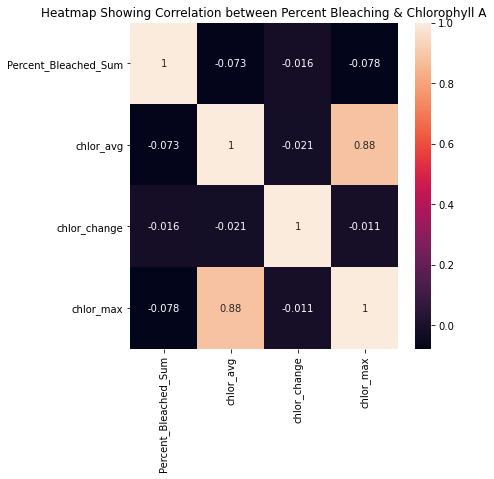

In [280]:
dfx=df_update[["Percent_Bleached_Sum", "chlor_avg","chlor_change", "chlor_max"]]
plt.figure(figsize=(6, 6))
sns.heatmap(dfx.corr(), annot=True)
plt.title("Heatmap Showing Correlation between Percent Bleaching & Chlorophyll A")
plt.show()

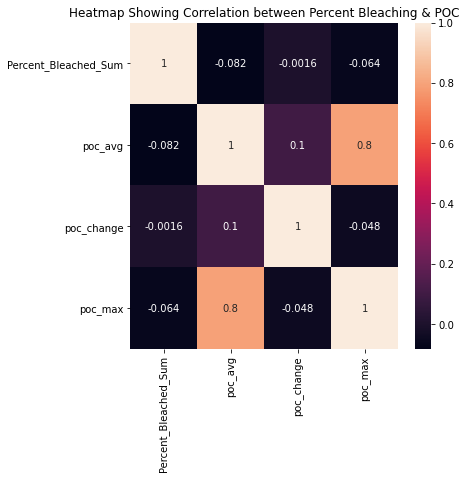

In [279]:
dfx=df_update[["Percent_Bleached_Sum", "poc_avg","poc_change", "poc_max"]]
plt.figure(figsize=(6, 6))
sns.heatmap(dfx.corr(), annot=True)
plt.title("Heatmap Showing Correlation between Percent Bleaching & POC")
plt.show()

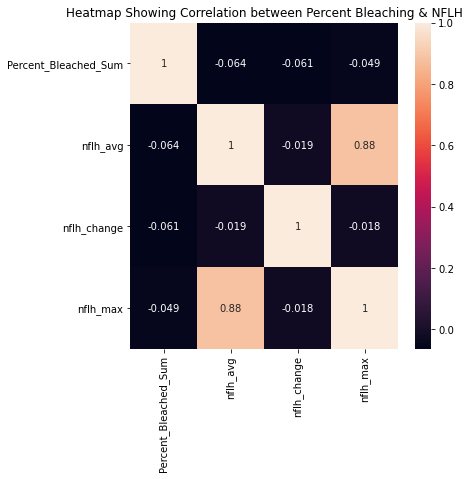

In [278]:
dfx=df_update[["Percent_Bleached_Sum", "nflh_avg","nflh_change", "nflh_max"]]
plt.figure(figsize=(6, 6))
sns.heatmap(dfx.corr(), annot=True)
plt.title("Heatmap Showing Correlation between Percent Bleaching & NFLH")
plt.show()

The below is code to perform exploratory analysis on one point in the GCB dataset. The point is selected by specifying the latitude and longitude (in this case only lat is specified since it has only one long degree. If this code is to be reproduced, a longitude should be specified and added as a constraint in the following cell.

In [285]:
#This is a filtering technique to narrow down to the one point found on index three of the above dataframe
df_sample1=dfGCBDModis[dfGCBDModis['Latitude_Degrees']==-26.645000]
df_sample1['Date']=df_sample1['Date'].astype(str)
df_sample1

<ipython-input-285-e0473747635f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample1['Date']=df_sample1['Date'].astype(str)


,Date,Latitude_Degrees,Longitude_Degrees,Percent_Bleached_Sum,Percent_Cover_Sum,chlor_a,chlor_avg,chlor_change,chlor_max,chlor_min,...,nflh_change,nflh_max,nflh_min,poc,poc_avg,poc_change,poc_max,poc_min,time_span,year
16433,2014-05-24,-26.645,153.160806,1.75,28.750,NaN,0.756959,-0.039606,0.737156,0.737156,...,-0.045900,0.129335,0.083435,NaN,155.199997,21.600006,166.000000,144.399994,3,2014
16435,2014-11-30,-26.645,153.160806,12.50,27.500,NaN,0.672914,-0.251007,0.547410,0.547410,...,-0.022695,0.079440,0.056745,NaN,142.000000,-50.000000,167.000000,117.000000,7,2014
16437,2015-11-21,-26.645,153.160806,6.25,35.000,NaN,0.345342,0.000000,0.345342,0.345342,...,0.000000,0.004130,0.004130,NaN,90.199997,0.000000,90.199997,90.199997,0,2015
16439,2016-11-12,-26.645,153.160806,1.00,36.875,NaN,4.290263,0.000000,4.290263,4.290263,...,0.000000,0.075530,0.075530,NaN,338.399994,0.000000,338.399994,338.399994,0,2016
16441,2014-05-24,-26.645,153.160806,4.25,39.375,NaN,0.756959,-0.039606,0.737156,0.737156,...,-0.045900,0.129335,0.083435,NaN,155.199997,21.600006,166.000000,144.399994,3,2014
16443,2015-03-07,-26.645,153.160806,1.50,35.000,NaN,2.317584,3.226429,0.456550,0.456550,...,0.013430,0.219945,0.055385,NaN,328.449995,450.399986,557.799988,107.400002,23,2015
16445,2015-10-18,-26.645,153.160806,0.00,32.500,NaN,0.273288,0.124628,0.218339,0.218339,...,-0.037060,0.084880,-0.002500,NaN,79.933332,24.400002,92.599998,68.199997,25,2015
16447,2017-01-27,-26.645,153.160806,0.00,37.500,NaN,1.060421,-0.257457,0.931693,0.931693,...,-0.048280,0.161635,0.113355,NaN,163.300003,-19.000000,172.800003,153.800003,16,2017
16449,2016-11-13,-26.645,153.160806,1.00,35.625,NaN,4.290263,0.000000,4.290263,4.290263,...,0.000000,0.075530,0.075530,NaN,338.399994,0.000000,338.399994,338.399994,0,2016
16451,2017-10-14,-26.645,153.160806,0.50,38.750,NaN,0.586057,0.148282,0.511916,0.511916,...,0.037400,0.075615,0.038215,NaN,157.099998,1.400009,157.800003,156.399994,16,2017


No handles with labels found to put in legend.


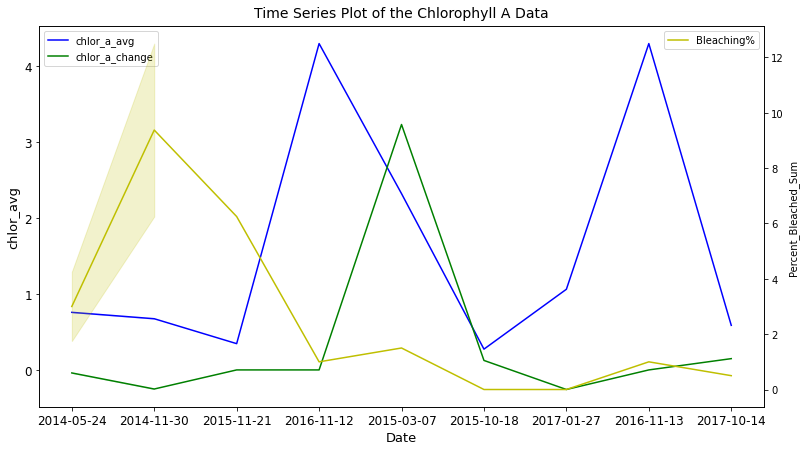

In [330]:
#plotting the time series data
fig=plt.figure(figsize = (13,7))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Date',fontsize=13)
plt.ylabel('chlor_avg',fontsize=13)
sns.lineplot(x = 'Date', y = "chlor_avg",data = df_sample1,color='blue',label="chlor_a_avg")
sns.lineplot(x = 'Date', y = "chlor_change",data = df_sample1,color='green',label="chlor_a_change")
ax2 = plt.twinx()
sns.lineplot(x = 'Date', y = "Percent_Bleached_Sum",data=df_sample1, color="y", ax=ax2,label="Bleaching%")
plt.title("Time Series Plot of the Chlorophyll A Data", 
          size=14, verticalalignment='bottom')
ax.legend (loc="upper right")
plt.show()